Inspired by [paper](https://www.researchgate.net/publication/237135894_A_unifying_framework_for_complexity_measures_of_finite_systems)

In this notebook I will implement TSE and Excess Entropy calculation and test it on following datasets:



1.   Wikipedia
2.   Simple English Wikipedia


# Preparation

In [1]:
!python3 -m pip install sentencepiece > /dev/null && echo 'OK'

OK


In [2]:
!python3 -m pip install tensorflow_text > /dev/null && echo 'OK'

OK


In [3]:
!python3 -m pip install tensorflow_datasets > /dev/null && echo 'OK'

OK


In [4]:
!python3 -m pip install tf_sentencepiece > /dev/null && echo 'OK'

OK


### Imports

In [5]:
import sentencepiece as spm
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import numpy as np
from typing import List, Tuple
import nltk
import matplotlib.pyplot as plt

# Datasets

## Wikipedia

[link](https://www.tensorflow.org/datasets/catalog/wiki40b#wiki40ben_default_config) to dataset

In [6]:
ds = tfds.load('wiki40b/en', split='train', shuffle_files=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset wiki40b downloaded and prepared to /root/tensorflow_datasets/wiki40b/en/1.3.0. Subsequent calls will reuse this data.


In [127]:
MAX_TEXTS_SIZE = 10000

texts = []
for x in ds:
    if len(texts) > MAX_TEXTS_SIZE:
        break
    s = x['text'].numpy().decode('utf-8')
    text = s.replace('_NEWLINE_', ' ').replace('_START_ARTICLE_', '').replace('_START_PARAGRAPH_', '').replace('_START_SECTION_',' ').split('\n')
    texts += list(filter(lambda x: len(x) > 20, text))

In [128]:
with open('train_text.txt', 'w') as fout:
    for text in texts:
        fout.write(text)
        fout.write('\n')

In [129]:
spm.SentencePieceTrainer.train('--input=train_text.txt --model_prefix=m --vocab_size=500')

In [130]:
print(list(sp.id_to_piece(i) for i in range(sp.vocab_size())))
print(sp.vocab_size())

['<unk>', '<s>', '</s>', 's', '▁', 'e', '▁the', ',', 't', 'a', '.', 'o', 'n', '▁a', 'ed', 'd', 'c', '▁in', '▁of', 'i', 'y', 'er', 'p', '▁and', 'ing', 'u', 'm', '▁to', 'al', 'ar', 'h', '▁s', 'b', 'or', 'g', 'f', 'w', 'r', 're', 'in', 'en', 'le', 'an', 'on', 'ur', '▁c', 'l', 'k', '▁was', 'ri', '▁S', '▁f', 'ch', 'st', '▁re', 'th', '▁A', '▁C', 'v', '-', 'ra', 'it', '▁The', 'ro', 'es', '▁B', '▁for', '▁p', 'ic', 'il', 'ly', 'ent', "'", 'ter', '▁(', '▁P', '1', '▁on', 'am', '▁be', '▁b', 'at', '▁with', 'ad', '▁T', 'ation', '▁D', ')', '▁is', '▁19', '▁as', 'us', '▁M', 'el', 'ne', '▁In', '▁H', '▁F', '5', 'lo', 'li', '0', '9', '▁de', '▁W', '▁his', 'ce', '▁by', 'un', '▁he', '8', '▁m', '2', 'om', '4', '7', 'la', '▁2', 'as', '▁G', '6', 'nd', '▁N', 'is', 'ol', '▁d', '"', 'se', '▁g', 'vi', '▁1', '▁at', '▁that', 'ver', 'ng', '▁st', 'et', 'ir', '3', '▁con', 'all', 'ion', 'im', 've', 'x', 'ut', '▁"', 'te', '▁from', 'ate', 'ul', 'z', '▁t', '▁e', '▁mo', 'ive', 'id', '▁K', 'ment', 'ck', '▁an', '▁l', '▁ha', '▁

In [131]:
sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [132]:
print(sp.encode_as_ids('Hello, my friend'))
print(sp.encode_as_pieces('Hello, my friend'))

[100, 226, 11, 7, 87, 19, 44, 38, 189]
['▁H', 'ell', 'o', ',', '▁m', 'y', '▁f', 'ri', 'end']


In [133]:
def collect_statistics(
    texts: List[str], 
    sp: spm.SentencePieceProcessor
) -> Tuple[np.ndarray]:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer

    Returns
    - a nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    - a nltk.FreqDist with counts for (i, x_i)
    """

    vocab_size = sp.vocab_size()
    bins = np.arange(vocab_size + 1)

    F_pair = nltk.FreqDist()
    F_single = nltk.FreqDist()

    for text in tqdm(texts):
        tokenized_sequence = sp.encode_as_ids(text)
        bgs = nltk.bigrams(tokenized_sequence)
        F_pair += nltk.FreqDist(zip(range(1, len(tokenized_sequence)), bgs))
        F_single += nltk.FreqDist(zip(range(len(tokenized_sequence)), tokenized_sequence))
    
    return F_pair, F_single

In [134]:
F_pair, F_single = collect_statistics(texts, sp)

## Simple English wikipedia

some [link](https://github.com/LGDoor/Dump-of-Simple-English-Wiki)

# Calculating metrics

## Excess Entropy

Friendly reminder:

Suppose that we have a sequence of tokens $x_0, x_1, \ldots, x_{n-1}$.
We want to calculate $E(x_0, x_1, \ldots, x_{n-1})$

In original papers this metrics can be calculated only of some multidimensional random value, but not of sequence of numbers. 

So, $E(X_0, X_1, \ldots, X_{n-1}) = (n-1)\left(\frac{1}{n-1}\sum\limits_{i=0}^{n-1}H(X_0, X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_{n-1}) - H(X_0, \ldots, X_{n-1})\right)$

The problem is how to calculate $H(\ldots)$ if we have only a sequence of numbers.

First of all, let's simplify the problem: we want to create such r.v. $\xi_i$ from our numbers in such a way that $H(\xi_0, \ldots, \xi_{n-1}) = H(\xi_0) + H(\xi_1|\xi_0) + \ldots + H(\xi_{n-1}|\xi_{n-2})$. How can we find such r.v.?

Notice that $xi_i$ should depends on the position ($i$) in the sequence and on number at this position ($x_i$).

Let's construct r.v. by $x_i$. So, $x_i$ will generate r.v. $\xi^i_{x_i}$. What the distribution of such r.v. is?

* $p(\xi^0_{x_0}) = \frac{\#\text{sequences with $x_0$ at the very beginning}}{\#\text{of first positions}}$

* $p(\xi^i_{x_i} | \xi^{i-1}_{x_{i-1}}) = \frac{\#\text{sequences with $x_{i-1}$ at position $i-1$ and $x_i$ at position $x_i$}}{\#\text{sequences with $i$-th position}}$

Then we can define Excess Entropy of sequence of numbers

$E(x_0, \ldots, x_{n-1}) = E(\xi^0_{x_0}, \xi^1_{x_1}, \ldots, \xi^{n-1}_{x_{n-1}})$

How to calculate it efficiently?

Let's denote $\mu_i = \xi^i_{x_i}$

* $\hat{H} = H(\mu_0, \ldots, \mu_{n-1}) = H(\mu_0) + H(\mu_1|\mu_0) + \ldots + H(\mu_{n-1} | \mu_{n-2})$
    * $H(\mu_i) = -p(\mu_i)\log p(\mu_i)$
    * $H(\mu_i|\mu_{i-1}) = -p(\mu_i|\mu_{i-1})\log p(\mu_i|\mu_{i-1})$
* $H(\mu_0, \ldots, \mu_{i-1}, \mu_{i+1}, \ldots, \mu_{n-1}) = \hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1}|\mu_{i-1}) = $
$=\hat{H} - H(\mu_i|\mu_{i-1}) - H(\mu_{i+1}|\mu_i) + H(\mu_{i+1})$

So, we can easily calculate Excess Entropy in $O(n)$ time

**Note**: if we will define r.v. which depends only on values then we can not easily calculate Excess entropy, because there is dependency between all r.v.

In [135]:
def calculate_excess_entropy(
    texts: List[str], 
    sp: spm.SentencePieceProcessor,
    F_pair: nltk.FreqDist,
    F_single: nltk.FreqDist
) -> np.ndarray:
    """
    texts: the list of str texts
    sp: pretrained sentencepieces tokenizer
    F_pair: nltk.FreqDist with counts for (i, (x_{i-1}, x_i))
    F_single: nltk.FreqDist with counts for (i, x_i)

    Returns
    - a (# of texts,) numpy array with excess entropy calculated for each text
    """

    EPS = 1e-9
    def calculate_entropy(p):
        return -p * np.log(p + EPS) - (1 - p) * np.log(1 - p)

    def H_pair(i, prev, cur):
        return calculate_entropy(F_pair.freq((i, (prev, cur))))

    def H_single(i, xi):
        return calculate_entropy(F_single.freq((i, xi)))

    ee = np.zeros(len(texts), dtype=float)

    for id, text in tqdm(enumerate(texts)):
        x = sp.encode_as_ids(text)
        n = len(x)
        H_hat = 0
        delta = 0
        for i in range(n):
            if i == 0:
                H_hat += H_single(0, x[i])
            else:
                H_hat += H_pair(i, x[i - 1], x[i])

            if i > 0:
                delta += -H_pair(i, x[i - 1], x[i])
            if i + 1 < n:
                delta += -H_pair(i + 1, x[i], x[i + 1]) + H_single(i + 1, x[i + 1])
        ee[id] = delta + H_hat

    return ee

In [136]:
ee = calculate_excess_entropy(
    texts,
    sp,
    F_pair,
    F_single
)

In [137]:
print(ee.min(), ee.max(), ee.mean(), ee.std())

0.0006173471416338807 0.11830589345881981 0.03996773989250456 0.030246260994301662


In [138]:
ee.min(), ee.max()

(0.0006173471416338807, 0.11830589345881981)

In [139]:
lens = np.array([len(sp.encode_as_ids(text)) for text in texts])

''

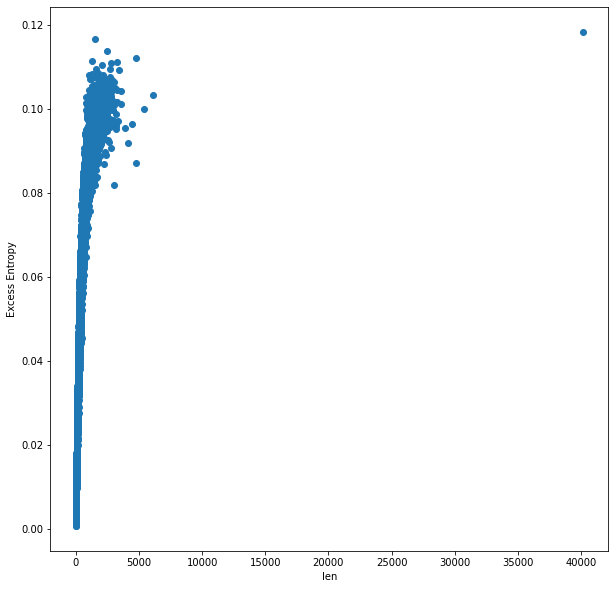

In [140]:
plt.figure(figsize=(10, 10))
plt.xlabel('len')
plt.ylabel('Excess Entropy')
plt.scatter(lens, ee)
;

## TSE Complexity

We have sequence of numbers (tokens): $x_0, \ldots, x_{n-1}$

Let's denote 
* $V_i = \{0, 1, \ldots, i\}$
* $V = V_{n-1}$
* $\mu_A = \mu_{i_0}, \mu_{i_1}, \ldots, \mu_{i_{k-1}}$, where $A = \{i_0, i_1, \ldots, i_{k-1}\}$ and $i_{j} < i_{j+1}$


TSE Complexity is $C(\mu_V) = \sum\limits_{k=1}^{n-1}\frac{k}{n}C^{(k)}(\mu_V)$, where

$C^{(k)}(\mu_V) = \left[\frac{n}{k}\cdot\frac{1}{\binom{n}{k}}\sum\limits_{A\subset V, |A| = k}H(\mu_A)\right] - H(\mu_V)$

We already know, how to calculate $H(\mu_V)$.

How can we calculate left term of given formula. Let's use dynamic programming, which allows us to do it in $O(n^2)$ time complexity.

Let's define 

* $d(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_i, |A| = k} H(\mu_A)$, 

    where $0 \le i < n, 0 \le k < n$

* $d(i, 0) = 0$

    $\forall 0 \le i < n$

* $C^{(k)}(\mu_V) = \frac{n}{k}d(n - 1, k) - H(\mu_V)$
    
    $C(\mu_V) = \sum\limits_{k=1}^{n-1}\left(d(n - 1, k) - \frac{k}{n}H(\mu_v)\right) = \left[\sum\limits_{k=1}^{n-1}d(n-1,k)\right] - \frac{n-1}{2}H(\mu_V)$

Transition:

$d(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_i, |A| = k} H(\mu_A) =$

$=\left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k} H(\mu_A)\right]
+ \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k-1,} H(\mu_{A\cup\{i\}})\right]
=$

$=\left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1}, |A| = k} H(\mu_A)\right]
+ \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-1}H(\mu_{A\cup\{i\}})\right]
+ \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-2}H(\mu_{A\cup\{i-1,i\}})\right] = A + B + C$

Let's introduce two definitions
1. $d^0(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1},|A|=k}H(\mu_A)$. 
    
    $d^0(i, 0) = 0$
2. $d^1(i, k) = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-1},|A|=k-1}H(\mu_{A\cup{\{i\}}})$. 
    
    $d^1(i, 0) = 0$

then we have 
* $d(i, k) = d^0(i, k) + d^1(i, k)$
* $d^0(i, k) = d(i - 1, k)$

Then if $i > 0$

* $A = \frac{i-k}{i}d(i-1,k)$

* $B = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2},|A|=k-1}\left[H(\mu_A) + H(\mu_i)\right] = \left[\frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2},|A|=k-1}H(\mu_A)\right] + \frac{\binom{i-1}{k-1}}{\binom{i}{k}}H(\mu_i) =$

$= \frac{i-k}{i}d^0(i-1,k-1) + \frac{k}{i}H(\mu_i)$

* $C = \frac{1}{\binom{i}{k}}\sum\limits_{A\subset V_{i-2}, |A|=k-2}\left[H(\mu_{A\cup\{i-1\}}) + H(\mu_i|\mu_{i-1})\right] = \frac{i-k}{i}d^1(i-1,k-1) + \frac{\binom{i-1}{k-2}}{\binom{i}{k}}H(\mu_i|\mu_{i-1}) = $

$=\frac{i-k}{i}d^1(i-1,k-1) + \frac{k(k-1)}{i(i-k+1)}H(\mu_i|\mu_{i-1})$

**Note**: $\binom{i}{k}=\frac{i!}{k!(i-k)!}=\frac{(i-1)!i}{k!(i-1-k)!(i-k)}=\binom{i-1}{k}\frac{i}{i-k}$

if $i = 0$ then 
* $d(0, 1) = H(\mu_0)$
* $d(0, k) = 0$

    $\forall k > 1$
